In [175]:
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.dates as mdates
import xgboost as xgb

from tqdm import tqdm
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from datetime import datetime, timedelta

In [176]:
billboard_hot_100 = pd.read_csv("../billboard_hot_100.csv")

billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)

billboard_hot_100["last_week_position"] = pd.to_numeric(billboard_hot_100["last_week_position"], errors="coerce",
                                                        downcast="integer")

billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year

In [177]:
grouped = billboard_hot_100.groupby(["artist", "song_name"])
rows_to_add = []
for name, group in grouped:
    max_week = group["first_day_of_the_week"].max()
    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            rows_to_add.append({
                "artist": row["artist"],
                "song_name": row["song_name"],
                "first_day_of_the_week": row["first_day_of_the_week"] + timedelta(weeks=1),
                "position": 101,
                "last_week_position": row["position"],
                "position_rised": 0,
                "weeks_on_chart": row["weeks_on_chart"],
                "peak_position": row["peak_position"]
            })

billboard_hot_100_with_disappeared_songs = pd.concat([billboard_hot_100, pd.DataFrame.from_records(rows_to_add)], ignore_index=True)

In [178]:
def calculate_position_difference(position, last_week_position):
    if np.isnan(last_week_position):
        return 100 - position
    return last_week_position - position

billboard_hot_100_with_disappeared_songs["position_change"] = billboard_hot_100_with_disappeared_songs.apply(
    lambda x: calculate_position_difference(x["position"], x["last_week_position"]), axis=1)

In [179]:
# calculate probability of position change for each week and position
grouped = billboard_hot_100_with_disappeared_songs.groupby(["last_week_position",  "year"])
position_change_probabilities = grouped["position_change"].value_counts(normalize=True).rename("probability").reset_index()

In [180]:
position_change_probabilities

,last_week_position,year,position_change,probability
0,1.0,1958.0,0.0,0.571429
1,1.0,1958.0,-1.0,0.238095
2,1.0,1958.0,-2.0,0.142857
3,1.0,1958.0,-3.0,0.047619
4,1.0,1959.0,0.0,0.692308
...,...,...,...,...
139653,100.0,2022.0,16.0,0.058824
139654,100.0,2022.0,19.0,0.058824
139655,100.0,2022.0,21.0,0.058824
139656,100.0,2022.0,23.0,0.058824


In [181]:
# https://www.entechin.com/find-nearest-value-list-python/
def closest_value(input_set, input_value):
  arr = list(input_set)
  i = (np.abs(arr - input_value)).argmin()
 
  return arr[i]

In [182]:
new_data = []
new_data.append([])

song_id = 1

all_weeks = billboard_hot_100["first_day_of_the_week"].drop_duplicates().sort_values().to_list()

for i in range(1, 101):
    new_row = {"position": i, "last_week_position": np.nan, "peak_position": i, "weeks_on_chart": 1, "year": 1958, "first_day_of_the_week": all_weeks[0],
               "song_id": song_id}
    song_id += 1
    new_row = pd.DataFrame(new_row, index=[0])
    new_data[-1].append(new_row)

all_positions = range(1, 101)

for week in tqdm(all_weeks[1:]):
    year = week.year
    new_data.append([])
    positions_in_week = []
    data_copy = pd.concat(new_data[-2])

    for row_index, row in data_copy.iterrows():
        position_difference_probs = position_change_probabilities[(position_change_probabilities["last_week_position"] == row["position"]) &\
                            (position_change_probabilities["year"] == year)].sort_values(by="probability", ascending=False)
        #position_difference = position_difference_probs[position_difference_probs["probability"] <= random_v]["position_change"].iloc[0]
        if position_difference_probs.shape[0] == 0:
            continue
        position_differences = random.choices(position_difference_probs["position_change"].to_list(), weights=position_difference_probs["probability"].to_list(), k=1)
        position_difference = position_differences[0]
        next_position = np.max([1, int(row["position"] - position_difference)])
        next_position = np.min([next_position, 101])
        
        if next_position != 101 and next_position not in positions_in_week:
            new_row = {"position": next_position, "last_week_position": row["position"], "peak_position": np.min([row["position"], next_position]), "weeks_on_chart": row["weeks_on_chart"] + 1, "year": year,
                       "first_day_of_the_week": week, "song_id": row["song_id"]}
            new_row = pd.DataFrame(new_row, index=[0])
            new_data[-1].append(new_row)
            positions_in_week.append(next_position)
        elif next_position != 101 and next_position in positions_in_week:
            missing_positions = set(all_positions) - set(positions_in_week)
            new_position = closest_value(missing_positions, next_position)
            new_row = {"position": new_position, "last_week_position": row["position"], "peak_position": np.min([row["position"], new_position]), "weeks_on_chart": row["weeks_on_chart"] + 1, "year": year, "first_day_of_the_week": week,
                    "song_id": row["song_id"]}
            positions_in_week.append(new_position)
            new_row = pd.DataFrame(new_row, index=[0])
            new_data[-1].append(new_row)
            # if np.abs(next_position - new_position) <= 10:
            #     new_row = {"position": new_position, "last_week_position": row["position"], "peak_position": np.min([row["position"], new_position]), "weeks_on_chart": row["weeks_on_chart"] + 1, "year": year, "first_day_of_the_week": week,
            #             "song_id": row["song_id"]}
            #     positions_in_week.append(new_position)
            #     new_row = pd.DataFrame(new_row, index=[0])
            #     new_data[-1].append(new_row)

    missing_positions = set(all_positions) - set(positions_in_week)
    for i in missing_positions:
        new_row = {"position": i, "last_week_position": np.nan, "peak_position": i, "weeks_on_chart": 1, "year": year, "first_day_of_the_week": week,
            "song_id": song_id}
        new_row = pd.DataFrame(new_row, index=[0])
        new_data[-1].append(new_row)
        song_id += 1

100%|██████████| 3360/3360 [11:41<00:00,  4.79it/s] 


In [183]:
data_array = [item for sublist in new_data for item in sublist]

own_chart = pd.concat(data_array)

In [184]:
own_chart.to_csv("empirical_based_chart.csv")

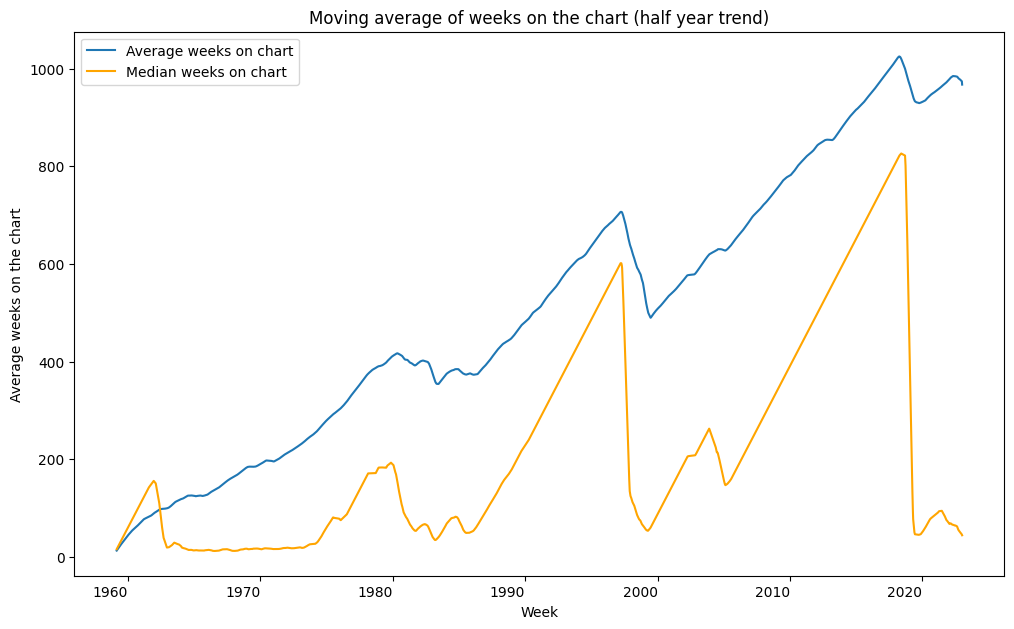

In [185]:
avg_weeks_on_chart = own_chart[["first_day_of_the_week", "weeks_on_chart"]].groupby(
    by="first_day_of_the_week").mean().rolling(window=30).mean()

median_weeks_on_chart = own_chart[["first_day_of_the_week", "weeks_on_chart"]].groupby(
    by="first_day_of_the_week").median().rolling(window=30).mean()

avg_weeks_on_chart_plot = avg_weeks_on_chart.plot(kind='line', figsize=(12, 8), legend=False, rot=0)
median_weeks_on_chart.plot(kind='line', figsize=(12, 8), legend=False, rot=0,
    ax=avg_weeks_on_chart_plot, color="orange")

# avg_weeks_on_chart_plot.axvline(x = spotify_creation_date, color = 'green')
# avg_weeks_on_chart_plot.axvline(x = youtube_creation_date, color = 'red')
# avg_weeks_on_chart_plot.axvline(x = apple_music_creation_date, color = 'pink')
# avg_weeks_on_chart_plot.axvline(x = mtv_launch_date, color = 'black')
# avg_weeks_on_chart_plot.axvline(x = cds_creation_date, color = 'turquoise')
# avg_weeks_on_chart_plot.axvline(x = mp3_creation_date, color = 'yellow')

plt.title("Moving average of weeks on the chart (half year trend)")
plt.xlabel("Week")
plt.ylabel("Average weeks on the chart")
plt.legend(["Average weeks on chart", "Median weeks on chart"])

#plt.savefig("figures/average_weeks_on_chart.pdf", format="pdf")#, bbox_inches="tight")
plt.show()

In [186]:
grouped = own_chart.groupby(["song_id"])
rows_to_add = []
for name, group in grouped:
    max_week = group["first_day_of_the_week"].max()
    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            rows_to_add.append({
                "song_id": row["song_id"],
                "first_day_of_the_week": row["first_day_of_the_week"] + timedelta(weeks=1),
                "position": 101,
                "last_week_position": row["position"],
                "peak_position": row["peak_position"],
                "weeks_on_chart": row["weeks_on_chart"],
                "year": row["year"]
            })

own_chart_with_disappeared_songs = pd.concat([billboard_hot_100, pd.DataFrame.from_records(rows_to_add)], ignore_index=True)

C:\Users\cutie\AppData\Local\Temp\ipykernel_15104\2837561770.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:


In [187]:
def calculate_position_difference(position, last_week_position):
    if np.isnan(last_week_position):
        return 100 - position
    return last_week_position - position

own_chart_with_disappeared_songs["position_change"] = own_chart_with_disappeared_songs.apply(
    lambda x: calculate_position_difference(x["position"], x["last_week_position"]), axis=1)

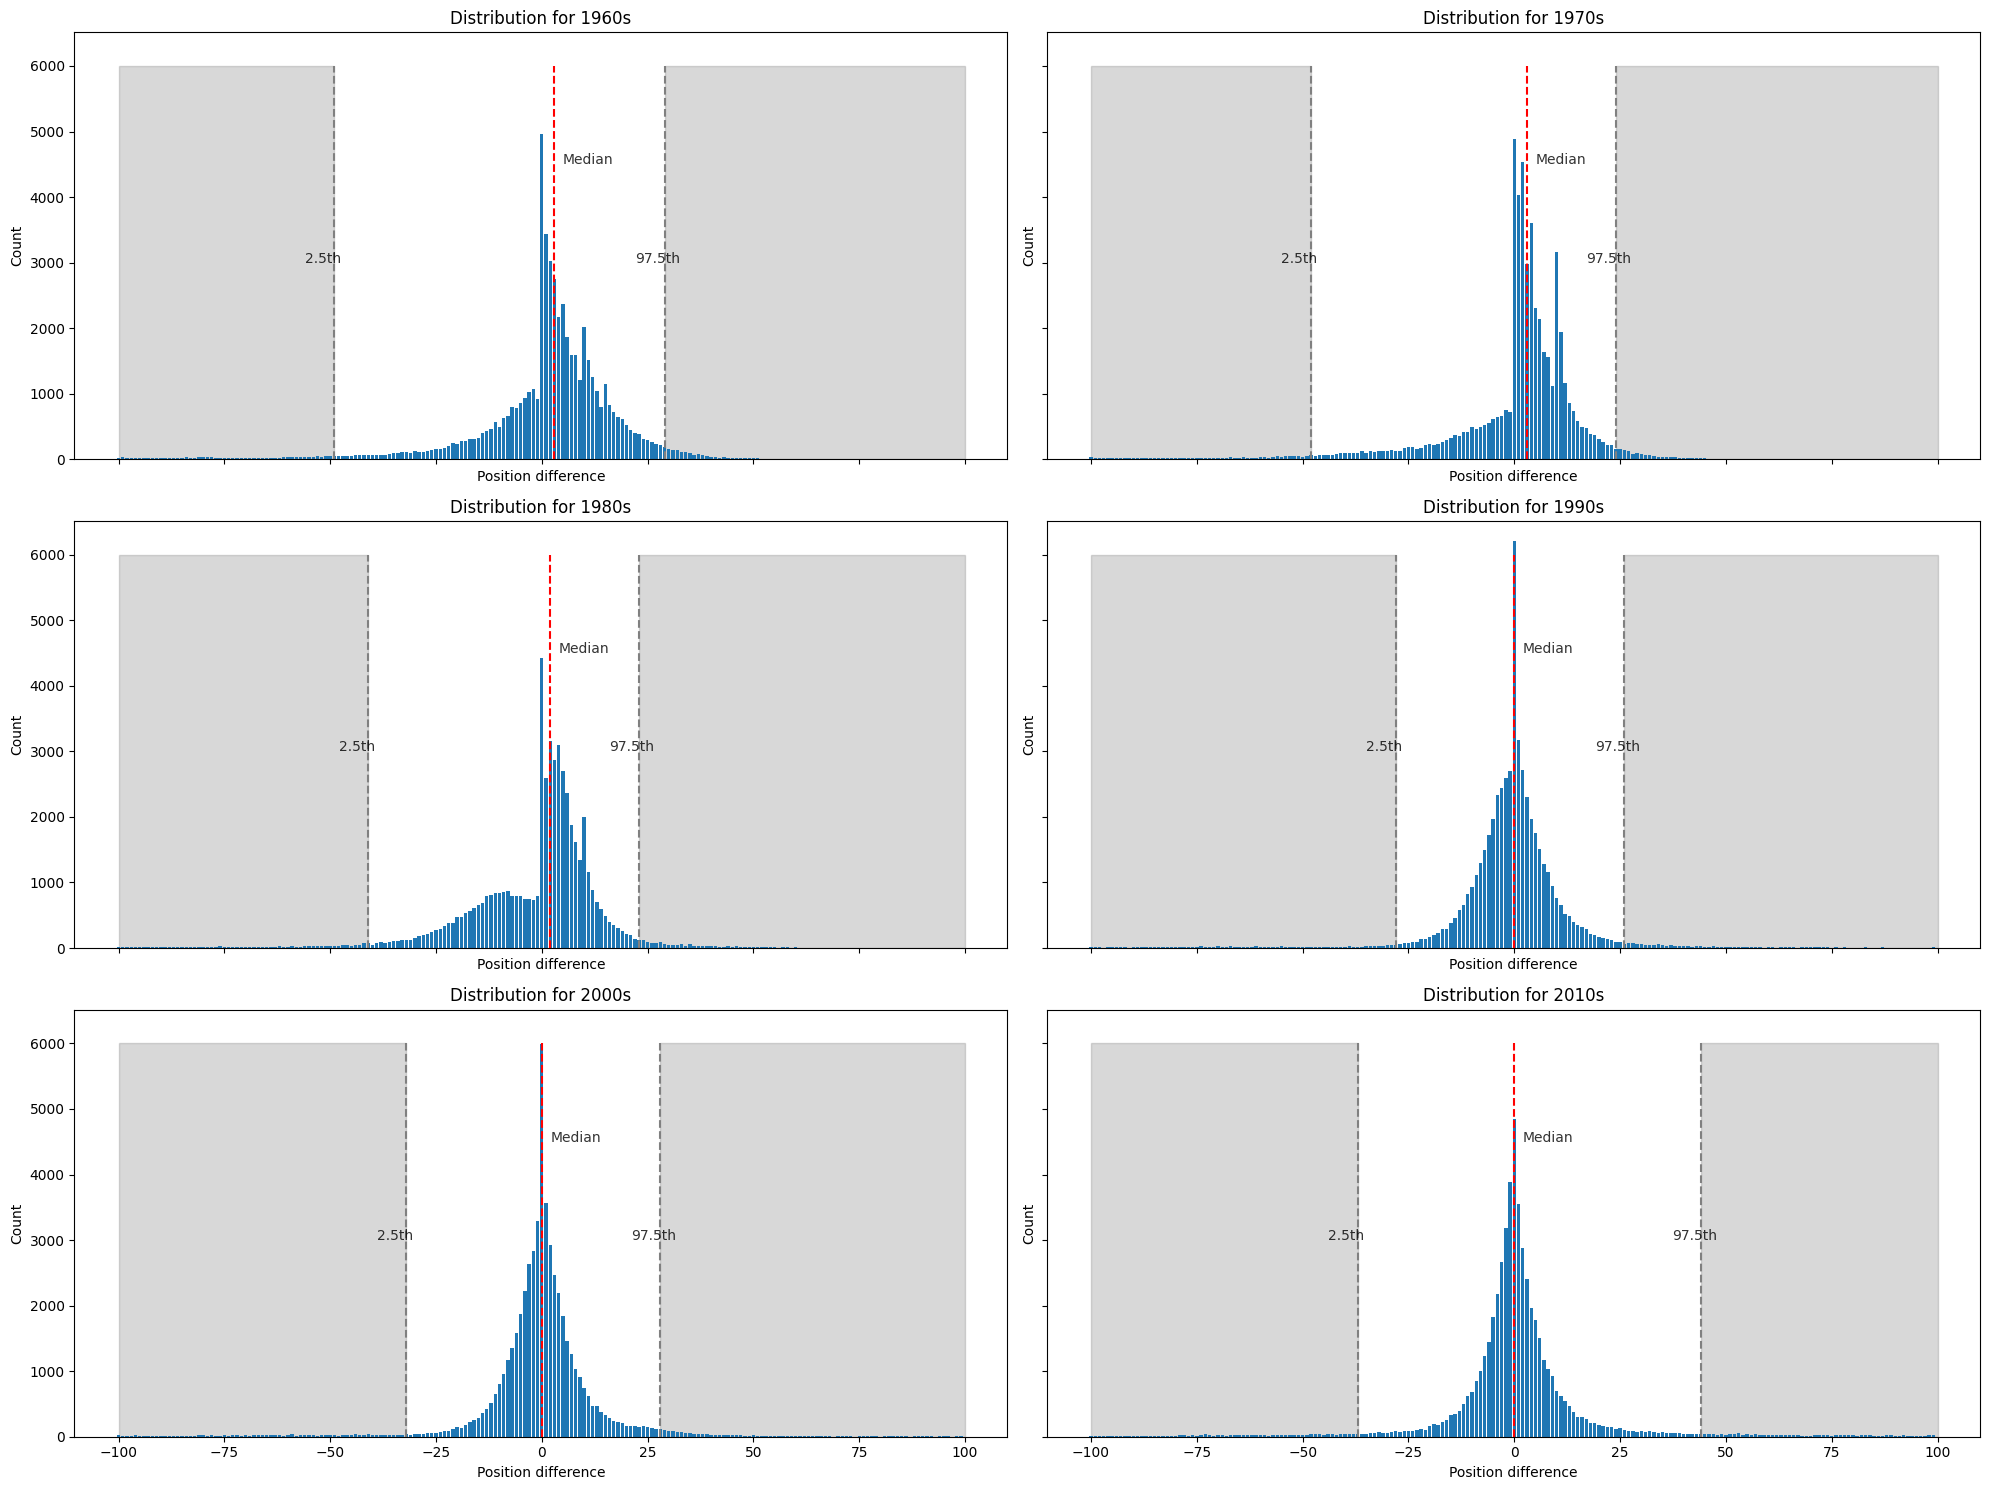

In [188]:
import matplotlib.patches as patches
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharex=True, sharey=True)

row = 0
col = 0

billboard_subset = own_chart_with_disappeared_songs[["year", "first_day_of_the_week", "position_change"]]

for year in range(1960, 2020, 10):
    decade_subset = billboard_subset[(billboard_subset["year"] >= year) &\
        (billboard_subset["year"] < year + 10)]["position_change"]
    count_changes = decade_subset.value_counts().sort_index()

    perecentile_25 = decade_subset.quantile(0.025)
    perecentile_975 = decade_subset.quantile(0.975)
    perecentile_50 = decade_subset.quantile(0.5)

    axes[row, col].vlines(perecentile_25, ymin=0, ymax=6000, color="grey", linestyle='--')
    axes[row, col].vlines(perecentile_975, ymin=0, ymax=6000, color="grey", linestyle='--')
    axes[row, col].vlines(perecentile_50, ymin=0, ymax=6000, color="red", linestyle='--')
    
    # mark the percentiles 
    rect_left = patches.Rectangle((-100, 0), 100 + perecentile_25, 6000, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    axes[row, col].add_patch(rect_left)
    axes[row, col].text(perecentile_25 - 7, 3000, "2.5th", size = 10, alpha = 0.8)
    rect_right = patches.Rectangle((perecentile_975, 0), 100 - perecentile_975, 6000, linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.3)
    axes[row, col].add_patch(rect_right)
    axes[row, col].text(perecentile_975 - 7, 3000, "97.5th", size = 10, alpha = 0.8)

    axes[row, col].text(perecentile_50 + 2, 4500, "Median", size = 10, alpha = 0.8)

    axes[row, col].bar(count_changes.index, count_changes.values)
    axes[row, col].set_title(f"Distribution for {year}s")
    axes[row, col].set_xlabel("Position difference")
    axes[row, col].set_ylabel("Count")
    axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(10))
    col += 1
    if col == 2:
        col = 0
        row += 1

plt.locator_params(axis='x', nbins=10)
fig.tight_layout()
plt.show()

In [189]:
own_chart["top_position"] = own_chart.groupby(
    ["song_id"])["position"].transform("min")

In [190]:
import dateutil.parser
rows_to_add = []

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = own_chart[(own_chart["year"] < year) |\
        (own_chart["year"] >= year + 10)][["song_id"]]
    
    songs_in_decade = own_chart[(own_chart["year"] >= year) &\
        (own_chart["year"] < year + 10) & ~(own_chart["song_id"].isin(songs_from_other_decades["song_id"]))][["song_id", "weeks_on_chart",
                "position", "first_day_of_the_week", "year", "top_position"]]
    grouped = songs_in_decade.groupby(["song_id"])

    min_first_week = songs_in_decade["first_day_of_the_week"].min().to_pydatetime()

    for name, group in grouped:
        max_week = group["first_day_of_the_week"].max().to_pydatetime()

        for row_index, row in group.iterrows():
            if row["first_day_of_the_week"] == max_week:
                week_date = row["first_day_of_the_week"] + timedelta(weeks=1)

                while week_date < dateutil.parser.parse(f"{year + 9}-12-31"):
                    rows_to_add.append({
                        "song_id": row["song_id"],
                        "weeks_on_chart": row["weeks_on_chart"],
                        "position": 101,
                        "first_day_of_the_week": week_date,
                        "year": week_date.year,
                        "top_position": row["top_position"]
                    })
                    week_date += timedelta(weeks=1)

own_chart_with_empty_weeks = pd.concat([own_chart[["song_id",
    "weeks_on_chart", "position", "first_day_of_the_week", "year", "top_position"]], pd.DataFrame(rows_to_add)], ignore_index=True)

C:\Users\cutie\AppData\Local\Temp\ipykernel_15104\3995549574.py:16: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:
C:\Users\cutie\AppData\Local\Temp\ipykernel_15104\3995549574.py:16: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:
C:\Users\cutie\AppData\Local\Temp\ipykernel_15104\3995549574.py:16: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:


In [ ]:
own_chart_with_empty_weeks["first_week"] = own_chart_with_empty_weeks.groupby(["song_id"])["first_day_of_the_week"].transform("min")

ValueError: Columns must be same length as key

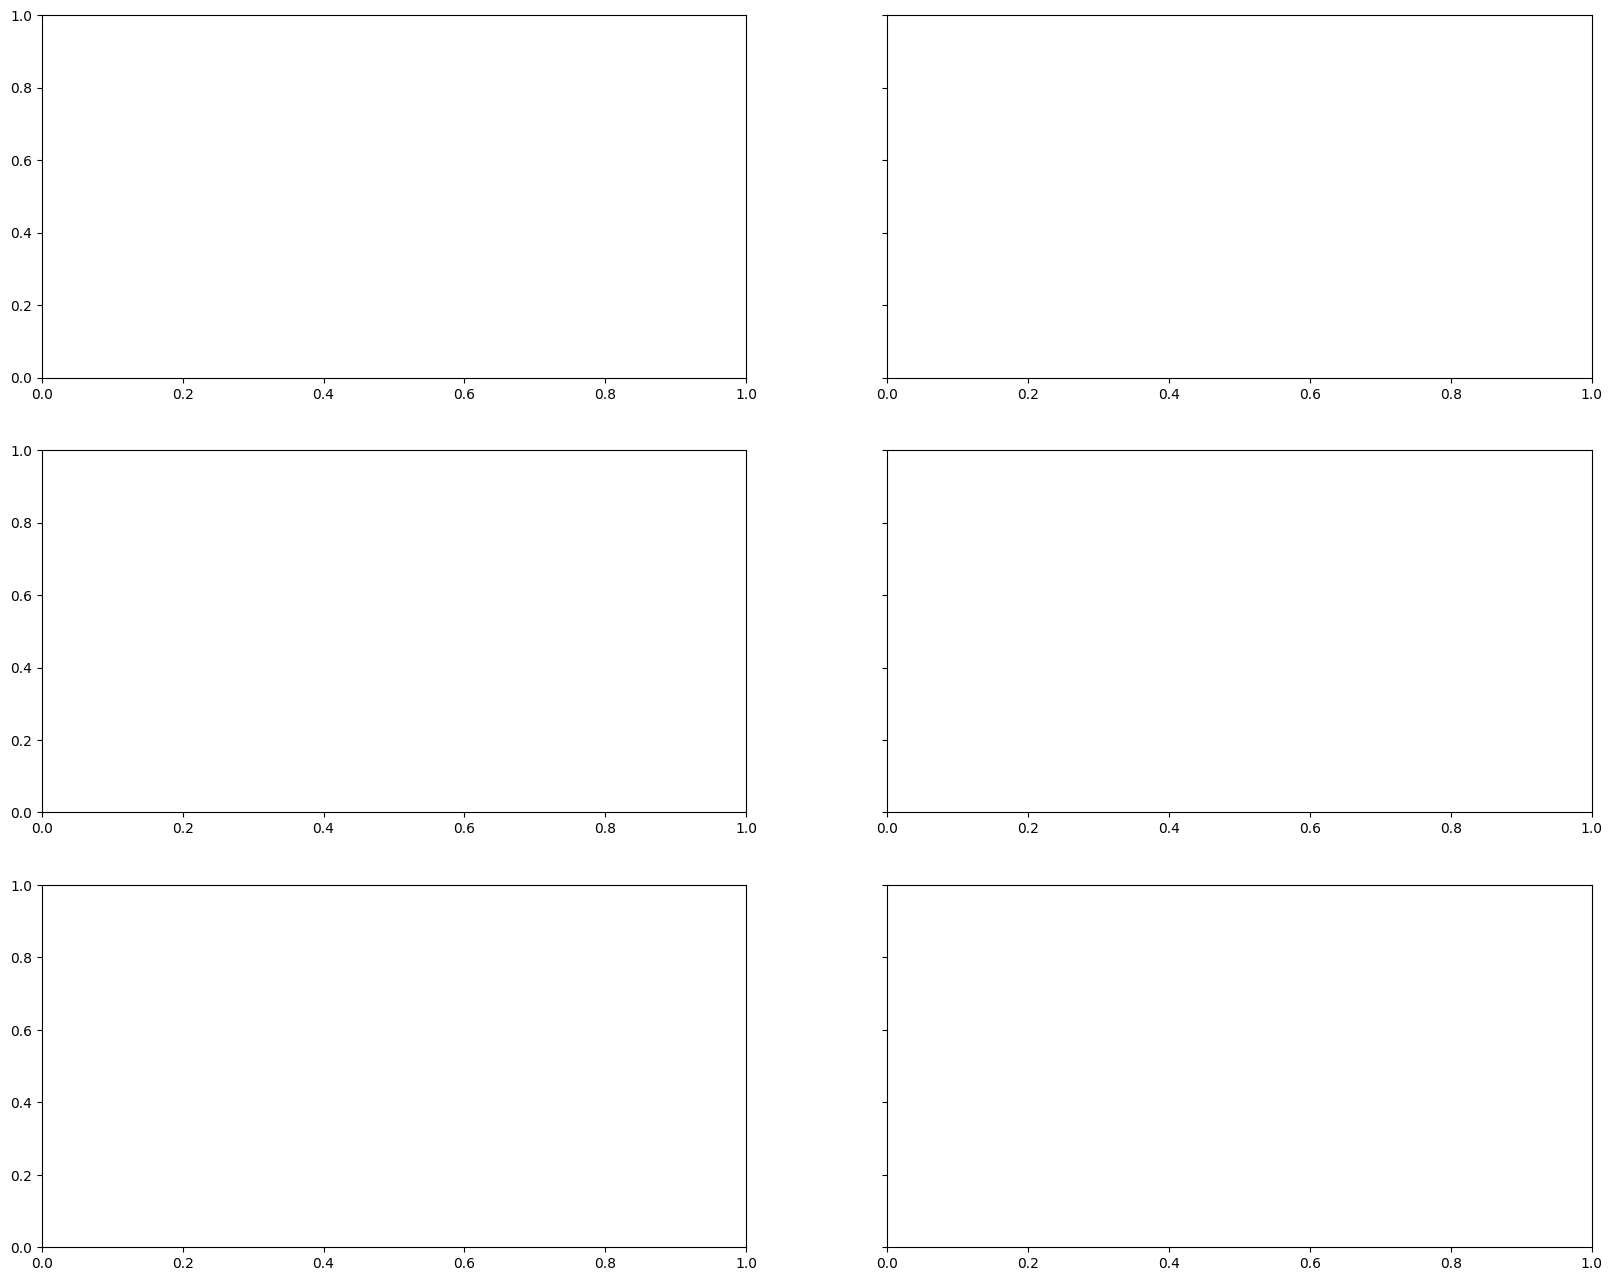

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(20, 16), sharey=True)

col_i = 0
row_i = 0

for year in range(1960, 2020, 10):
    # all songs in the decade
    all_songs_in_decade = own_chart_with_empty_weeks[(own_chart_with_empty_weeks["year"] >= year) &\
        (own_chart_with_empty_weeks["year"] < year + 10)][["song_id", "first_day_of_the_week", "top_position", "position",
            "first_week"]]

    # songs from other decades
    songs_from_other_decades = own_chart[(own_chart["year"] < year) |\
        (own_chart["year"] >= year + 10)][["song_id"]]

    for top_position in range(10, 110, 10):
        # songs that reached top 50 in the decade
        top_x_positions_in_decade = all_songs_in_decade[(all_songs_in_decade["top_position"] <= top_position) &\
            (all_songs_in_decade["top_position"] > top_position - 10)][["song_id"]]

        # take songs only from this decade
        top_x_positions_in_decade = top_x_positions_in_decade[~top_x_positions_in_decade["song_id"].isin(songs_from_other_decades["song_id"])]

        # take all positions of the songs
        top_x_positions_in_decade = top_x_positions_in_decade[["song_id"]].drop_duplicates().merge(
            own_chart_with_empty_weeks[["song_id",
                "position", "first_day_of_the_week", "first_week"]], on=["song_id"], how="left")

        min_first_week = top_x_positions_in_decade["first_day_of_the_week"].min().to_pydatetime()

        top_x_positions_in_decade["first_day_of_the_week"] = top_x_positions_in_decade.apply(lambda row:
            int(((min_first_week + timedelta(
                    days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

        top_x_positions_in_decade.set_index("first_day_of_the_week", inplace=True)

        axes[row_i, col_i].plot(top_x_positions_in_decade.groupby("first_day_of_the_week")["position"].mean(),
            marker='o', label=f"Top {top_position - 9}-{top_position}")

    axes[row_i, col_i].set_title(f"Average position change of songs in {year}s")
    axes[row_i, col_i].set_xlabel("Week")
    axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].set_xlim(0, 100)
    axes[row_i, col_i].legend()

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.show()